In [2]:
import netCDF4 as nc
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import scipy
import plotly.express as px
from scipy.stats import mstats
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math
import csv
import fiona
import geopandas
#pd.set_option('display.max_rows', 200)

In [3]:
#loading in mortality dataset from hierarchy file (available on Zenodo)
#fn is the full aggregated dataset
fn = "/Users/danielblanco/Documents/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single/rcp85/CCSM4/low/SSP3/Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-noadapt.nc4"

#fn1 is the HistClim dataset
fn1 = "/Users/danielblanco/Documents/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single/rcp85/CCSM4/low/SSP3/Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-histclim-aggregated.nc4"

In [4]:
#loading in shapefile associated with hierarchy file
shapefile = "/Users/danielblanco/Documents/Mortality_Project/impact-regions-highres-full"

sf = geopandas.read_file(shapefile)
print(sf.head())

    gadmid           hierid  color  ISO  \
0  28115.0       CAN.1.2.28    1.0  CAN   
1  28116.0     CAN.1.17.403    2.0  CAN   
2  28119.0     CAN.2.34.951    3.0  CAN   
3  28120.0  CAN.11.259.4274    4.0  CAN   
4  28124.0  CAN.11.269.4448    5.0  CAN   

                                            geometry  
0  MULTIPOLYGON (((-110.05459 53.30730, -110.0911...  
1  POLYGON ((-111.23055 52.91943, -111.23056 52.9...  
2  POLYGON ((-127.68527 55.29570, -127.68806 55.2...  
3  POLYGON ((-77.73080 55.31879, -77.72983 55.318...  
4  POLYGON ((-66.25940 54.99975, -66.24916 54.999...  


In [5]:
def fix_region(ds):
    """Clean raw mortality Datasets so region is helpful.

    Changes coords/dims/vars so 'region' is region names we can select data by.
    For e.g. `ds.sel(region='IND.10.121')` should work properly.
    """
    return ds.set_coords("regions").swap_dims({"region": "regions"}).rename({"regions": "region"})


ds = fix_region(xr.open_dataset(fn))
ds1 = fix_region(xr.open_dataset(fn1))
ds1

<xarray.Dataset>
Dimensions:         (year: 120, region: 5678)
Coordinates:
  * year            (year) int32 1981 1982 1983 1984 ... 2097 2098 2099 2100
  * region          (region) object '' 'SSD.1.2.6' ... 'SYR.2' 'RUS.73.2026'
Data variables:
    rebased         (year, region) float32 ...
    transformed     (year, region) float32 ...
    response        (year, region) float32 ...
    climtas_effect  (year, region) float32 ...
Attributes:
    description:   Mortality impacts, with interpolation and adaptation throu...
    version:       Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-hist...
    dependencies:  AgglomMapping.2016-04-05.01, Agespec_interaction_GMFD_POLY...
    author:        James Rising

In [156]:

#isolating individual regions to analyze
DEL = ds.sel(region="IND.10.121")   
OSL = ds.sel(region='NOR.12')
CHI = ds.sel(region='USA.14')        #listed as 'Cook' county
SPB = ds.sel(region='BRA')        #double check aggregated version, unaggreagted version not listed as sao paulo
ACC = ds.sel(region='GHA.5')
SYD = ds.sel(region='AUS.4')         #unaggreageted version split into 
BEI = ds.sel(region='CHN.2')        #double check aggregated version, unaggregated version only has Miyun district

#isolating the regions again for the difference calculation down the road
DEL = ds1.sel(region='IND.10.121')   
OSL = ds1.sel(region='NOR.12')
CHI = ds1.sel(region='USA.14')        #listed as 'Cook' county
SPB = ds1.sel(region='BRA')        #double check aggregated version, unaggreagted version not listed as sao paulo
ACC = ds1.sel(region='GHA.5')
SYD = ds1.sel(region='AUS.4')         #unaggreageted version split into 
BEI = ds1.sel(region='CHN.2')

KeyError: "not all values found in index 'region'. Try setting the `method` keyword argument (example: method='nearest')."

In [170]:
q = (0.17, 0.5, 0.83)
window_n = 30
rebased_qs = ds["rebased"].rolling({"year": window_n}, center=False).construct("tmp").quantile(q,skipna= False, dim="tmp")
rebased_qs1 = ds1["rebased"].rolling({"year": window_n}, center=False).construct("tmp").quantile(q,skipna= False, dim="tmp")

In [172]:
##can use rebased_qs.sel(quantile=0.5, region="IND.10.121") to grab something
rebased_qs.stack(z=["region", "quantile"]).to_pandas()
#rebased_qs.sel(region="IND.10.121", quantile =0.17)

region   CAN.1.2.28                     CAN.1.17.403                      \
quantile       0.17      0.50      0.83         0.17      0.50      0.83   
year                                                                       
1981            NaN       NaN       NaN          NaN       NaN       NaN   
1982            NaN       NaN       NaN          NaN       NaN       NaN   
1983            NaN       NaN       NaN          NaN       NaN       NaN   
1984            NaN       NaN       NaN          NaN       NaN       NaN   
1985            NaN       NaN       NaN          NaN       NaN       NaN   
...             ...       ...       ...          ...       ...       ...   
2096      -0.006818 -0.005348 -0.004372    -0.005819 -0.004449 -0.003505   
2097      -0.006818 -0.005441 -0.004390    -0.005819 -0.004556 -0.003673   
2098      -0.006818 -0.005441 -0.004409    -0.005819 -0.004556 -0.003673   
2099      -0.006946 -0.005441 -0.004409    -0.005928 -0.004556 -0.003673   
2100      -0.006946 -0.005348 -0.004384    -0.005928 -0.004449 -0.003673   

region   CAN.2.34.951                     CAN.11.259.4274  ...     BWA.7  \
quantile         0.17      0.50      0.83            0.17  ...      0.83   
year                                                       ...             
1981              NaN       NaN       NaN             NaN  ...       NaN   
1982              NaN       NaN       NaN             NaN  ...       NaN   
1983              NaN       NaN       NaN             NaN  ...       NaN   
1984              NaN       NaN       NaN             NaN  ...       NaN   
1985              NaN       NaN       NaN             NaN  ...       NaN   
...               ...       ...       ...             ...  ...       ...   
2096        -0.006045 -0.004831 -0.003441       -0.007945  ...  0.003457   
2097        -0.006045 -0.004831 -0.003458       -0.008306  ...  0.003491   
2098        -0.006045 -0.004877 -0.003821       -0.008306  ...  0.003525   
2099        -0.006319 -0.004965 -0.003821       -0.008322  ...  0.003659   
2100        -0.006319 -0.004965 -0.003821       -0.008322  ...  0.003925   

region    BWA.6.16                         BWA.5                      \
quantile      0.17      0.50      0.83      0.17      0.50      0.83   
year                                                                   
1981           NaN       NaN       NaN       NaN       NaN       NaN   
1982           NaN       NaN       NaN       NaN       NaN       NaN   
1983           NaN       NaN       NaN       NaN       NaN       NaN   
1984           NaN       NaN       NaN       NaN       NaN       NaN   
1985           NaN       NaN       NaN       NaN       NaN       NaN   
...            ...       ...       ...       ...       ...       ...   
2096     -0.000351  0.000181  0.000756  0.000063  0.000755  0.002109   
2097     -0.000351  0.000239  0.001044  0.000063  0.000755  0.002191   
2098     -0.000351  0.000299  0.002219  0.000063  0.001021  0.002436   
2099     -0.000351  0.000299  0.002219  0.000137  0.001242  0.002436   
2100     -0.000351  0.000372  0.002219  0.000137  0.001345  0.002436   

region    BWA.4.13                      
quantile      0.17      0.50      0.83  
year                                    
1981           NaN       NaN       NaN  
1982           NaN       NaN       NaN  
1983           NaN       NaN       NaN  
1984           NaN       NaN       NaN  
1985           NaN       NaN       NaN  
...            ...       ...       ...  
2096      0.000140  0.000948  0.002693  
2097      0.000140  0.000948  0.002854  
2098      0.000140  0.001244  0.002865  
2099      0.000346  0.001553  0.002865  
2100      0.000346  0.001739  0.002865  

[120 rows x 73134 columns]

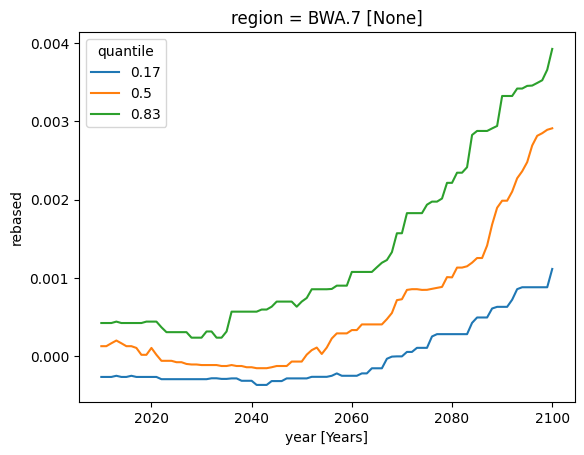

In [183]:
rebased_qs.sel(region="BWA.7").plot.line(x="year")

In [ ]:
##original code from Brewster
##threshold = rebased_qs.sel(quantile=0.17, year=window).max(dim="year")
##mask_years_over_threshold = rebased_qs.sel(quantile=0.83, year=window) <= threshold
##earliest_threshold_year = mask_years_over_threshold.idxmax(dim="year")

In [203]:
window = slice(2010, 2100)

threshold = rebased_qs.sel(quantile=0.17, year=2010)
mask_years_over_threshold = rebased_qs.sel(quantile=0.83, year=window) <= threshold
earliest_threshold_year = mask_years_over_threshold.idxmax(dim="year")
array1 = earliest_threshold_year['region'].values
array2 = earliest_threshold_year.values


---
# 230922 pk

In [209]:
def fun_threshold(quant,yr):
    threshold = rebased_qs.sel(quantile=quant, year=yr)
    return threshold

In [211]:
mask_years_over_threshold1 = fun_threshold(0.83, window) <= fun_threshold(0.17, 2100)
earliest_threshold_year1 = mask_years_over_threshold1.idxmax(dim="year")

In [ ]:
mask_years_over_threshold2 = fun_threshold(0.17, window) <= fun_threshold(0.83, 2100)
earliest_threshold_year2 = mask_years_over_threshold2.idxmax(dim="year")

---
# ^^^pk

In [ ]:
if:
    threshold(q=0.17,year=2000) -- first qunatile value
    mask_years_over_threshold = rebased_qs.sel(quantile=0.83, year=window) <= threshold -
    ##says if first 0.17 percntile becomes greater than 0.83 percentile at some year Y, damages occur (mortality increasin)
    ##opposite true of first 0.83 crosses 0.17 - benefits occur
    ##in some regions neither benefits nor damages emerge 
    #threshold 1 will find what year the 2010 0.17 percentile crosses 0.83
    #threshold 2 will find what year 2010 0.83 percnetile cross 0.17
    

In [207]:
array1.shape

(24378,)

In [132]:

threshold2 = rebased_qs.sel(quantile=0.83, year=2010)
mask_years_over_threshold2 = rebased_qs.sel(quantile=0.17, year=window) <= threshold2
earliest_threshold_year2 = mask_years_over_threshold2.idxmax(dim="year")

In [188]:
rebased_qs.sel(quantile[0=0.17, year=2010)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (4153846515.py, line 1)

In [133]:
sf['TOE_benefits'] = earliest_threshold_year
sf['TOE_damages'] = earliest_threshold_year2

<AxesSubplot: >

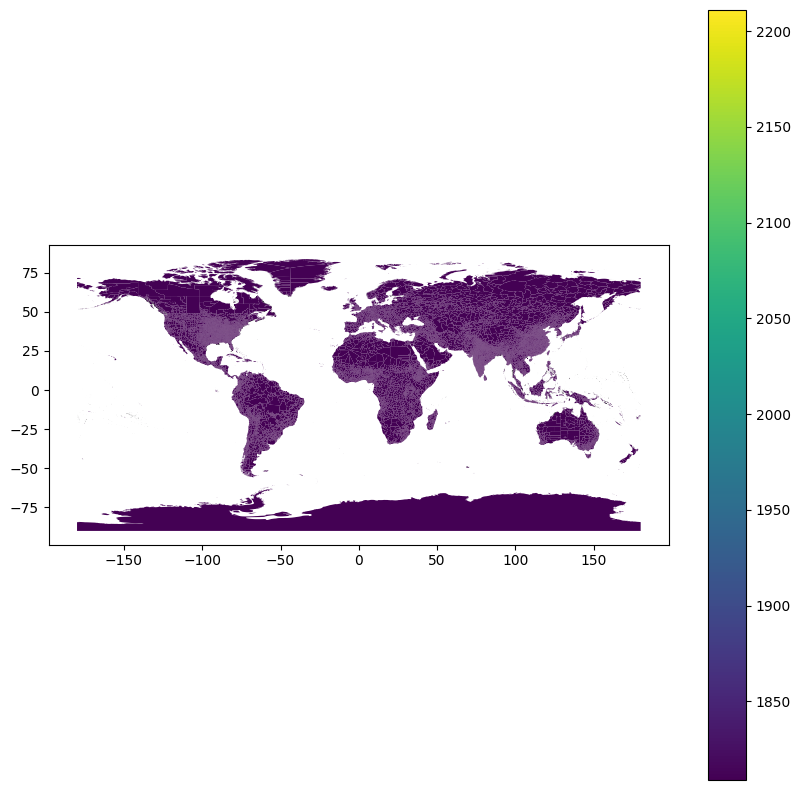

In [134]:
# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
sf.plot(column="TOE_damages",ax=ax,legend=True)

<AxesSubplot: >

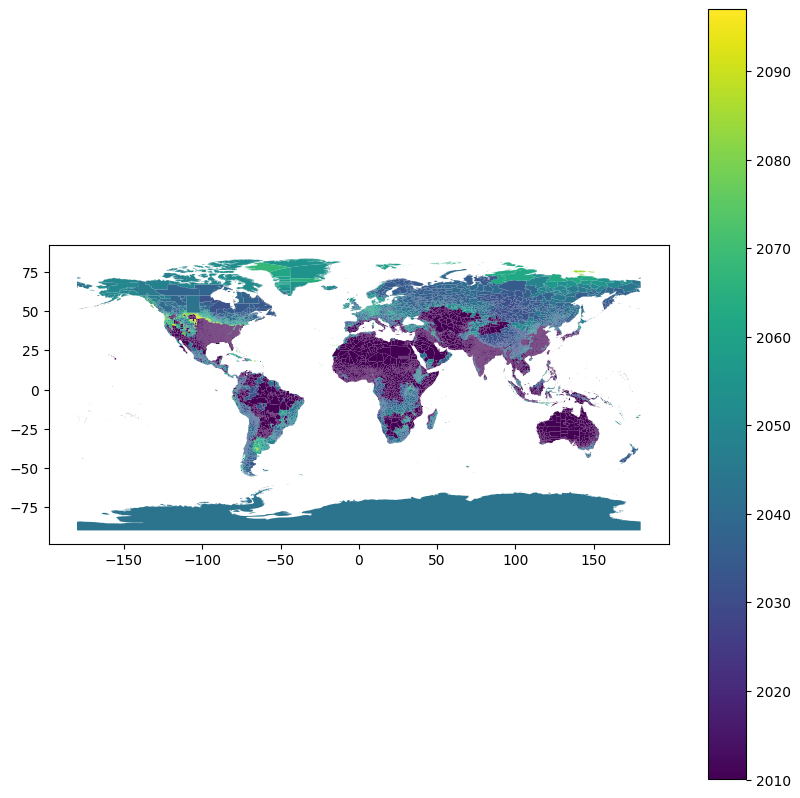

In [135]:
# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
sf.plot(column="TOE_benefits",ax=ax,legend=True)